# Fast track reconstruction in drift tube detectors


GRUPPO 15:
Lorenzo Borella, Mattia Ceravolo, Marco Giunta, Samuele Pio Lipani.

# Part 0

In [37]:
import pandas as pd
import numpy as np
import timeit as t
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import optimize

In [38]:
#DATA AQUISITION
dataset=pd.read_csv("data_000000.txt")

samples=dataset.shape[0]
print("Number of total hits:",samples)

triggers=dataset[dataset['TDC_CHANNEL']>=137].shape[0]
print("Number of total trigger activations:",triggers)

total_orbits=dataset['ORBIT_CNT'].nunique()
print("Number of unique orbits:",total_orbits)

#GET MORE DATA

dataset


FileNotFoundError: [Errno 2] File b'data_000000.txt' does not exist: b'data_000000.txt'

Abbiamo inserito i dati in un DataFrame di Pandas ed abbiamo stampato i parametri di interesse iniziali: numero di hits totali, numero di attivazioni dei trigger, numero di valori unici di ORBIT_CNT. (DATI DA INSERIRE ALLA FINE)

(FARE COMMENTI SULLA SCELTA DEI DATI: CALIBRATION E PHYSICS RUN).

In [3]:
#add ORBIT TIME column
dataset['TIME']=dataset['BX_COUNTER']*25 + dataset['TDC_MEAS']*25/30 #time at fixed orbit

#add DETECTOR column

fpga=dataset['FPGA']==1 #condition on FPGA
channel=(dataset['TDC_CHANNEL']>64)&(dataset['TDC_CHANNEL']<=128) #condition on TDC_CHANNEL
trigger=dataset['TDC_CHANNEL']>=137 #condition on trigger

detectors=[~fpga&~channel,~fpga&channel,fpga&~channel,fpga&channel] #list of conditions
for i in range(len(detectors)):dataset.loc[detectors[i],'DETECTOR']=i+1 #assign detector values
dataset.loc[trigger,'DETECTOR']=0 #re-assign trigger values

#add LAYER column
layer_1=dataset['TDC_CHANNEL']%4==0 
layer_2=(dataset['TDC_CHANNEL']+2)%4==0
layer_3=(dataset['TDC_CHANNEL']+1)%4==0
layer_4=(dataset['TDC_CHANNEL']+3)%4==0
trigger=dataset['TDC_CHANNEL']>=137 #trigger condition

layers=[layer_1,layer_2,layer_3,layer_4] #list of layer conditions
for i in range(len(layers)): dataset.loc[layers[i],'LAYER']=i+1 #assign layer values
dataset.loc[trigger,'LAYER']=0 #re-assign trigger values
    
#drop useless columns HEAD,FPGA
dataset=dataset.drop(['HEAD','FPGA'],axis=1) 

dataset



,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
0,116,1897414884,1533.0,24.0,38345.000000,4.0,1.0
1,71,1897414887,1650.0,21.0,41267.500000,4.0,3.0
2,67,1897414914,980.0,8.0,24506.666667,4.0,3.0
3,70,1897414922,1287.0,8.0,32181.666667,4.0,2.0
4,57,1897414922,2162.0,22.0,54068.333333,1.0,4.0
5,24,1897414934,2014.0,13.0,50360.833333,1.0,1.0
6,26,1897414934,2014.0,20.0,50366.666667,1.0,2.0
7,26,1897414934,2026.0,13.0,50660.833333,1.0,2.0
8,139,1897414934,2028.0,0.0,50700.000000,0.0,0.0
9,33,1897414934,2026.0,14.0,50661.666667,1.0,4.0


Per prima cosa abbiamo inserito all'interno del DataFrame le colonne TIME, DETECTOR e LAYER.

I valori assegnati nella colonna TIME corrispondono alla trasformazione dei tempi associati a ciascuna hit in ns . Per la derivazione di ognuno di questi valori non è stato considerato il valore di ORBIT_CNT, in quanto inutile per il proseguimento del progetto.

Per quanto riguarda la colonna DETECTOR, i valori sono stati assegnati secondo la mappatura prestabilita:
* Detector 1 $\rightarrow$ FPGA 0, TDC_CHANNEL in [1-64]
* Detector 2 $\rightarrow$ FPGA 0, TDC_CHANNEL in [65-128]
* Detector 3 $\rightarrow$ FPGA 1, TDC_CHANNEL in [1-64]
* Detector 4 $\rightarrow$ FPGA 1, TDC_CHANNEL in [65-128]

In corrispondenza delle attivazioni dei trigger è stato inserito un valore DETECTOR=0, in quanto questi non sono univocamente associabili ad alcun detector.

I valori inseriti nella colonna LAYER sono stati dedotti dai corrispettivi valori di TDC_CHANNEL, attuando alcune considerazioni sulla numerazione delle singole celle. Anche in questo caso, in corrispondenza delle attivazioni dei trigger, è stato assegnato un valore LAYER=0

Infine abbiamo eliminato le colonne HEAD e FPGA, non più utili ai fini del progetto.

Al fine di tradurre il nostro DataFrame in termini di singoli eventi, abbiamo apportato una serie di tagli, utili in seguito ad identificare più accuratamente i singoli eventi.

Per prima cosa abbiamo raggruppato i dati in termini del valore di ORBIT_CNT comune, dopodiché abbiamo eliminato tutti i gruppi che contenevano un numero di hits non sufficiente a descrivere un evento fisico.
Questo primo taglio mci ha portato ad avere una mole di dati utili pari al 68% del dataset originale.
(INSERIRE I DATI FINALI)


(BISOGNA DIRE CHE QUESTO TAGLIO E' UTILE SOLO PER FORNIRE AL TAGLIO SUCCESSIVO UNA MOLE INFERIORE DI DATI. HO PROVATO A FARE SOLO IL TAGLIO DELLA CELLA DOPO MA CI METTE UNA VITA!)

In [4]:
#FIRST CUT

#function to cut groups smaller than 3 hits
def cut(group):
    if group.shape[0]>2: return group
    else: return None
    
#filter dataset by length                          
filtered1=dataset.groupby(['ORBIT_CNT'],group_keys=False)\
                    .apply(cut)\
                    .dropna()\
                    .reset_index()\
                    .drop(['index'],axis=1)

orbits=filtered1['ORBIT_CNT'].nunique()

print("Number of unique orbits:",orbits)
print("Samples in reduced dataset:",filtered1.shape[0])
print("Percentage of the original dataset:",filtered1.shape[0]*100/samples,"%")



if orbits>triggers:print("NOTE:There are orbits with no trigger activation!")#check

filtered1

Number of unique orbits: 118626
Samples in reduced dataset: 879478
Percentage of the original dataset: 68.06441477069573 %
NOTE:There are orbits with no trigger activation!


,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
0,24.0,1.897415e+09,2014.0,13.0,50360.833333,1.0,1.0
1,26.0,1.897415e+09,2014.0,20.0,50366.666667,1.0,2.0
2,26.0,1.897415e+09,2026.0,13.0,50660.833333,1.0,2.0
3,139.0,1.897415e+09,2028.0,0.0,50700.000000,0.0,0.0
4,33.0,1.897415e+09,2026.0,14.0,50661.666667,1.0,4.0
5,27.0,1.897415e+09,2024.0,11.0,50609.166667,1.0,3.0
6,29.0,1.897415e+09,2026.0,9.0,50657.500000,1.0,4.0
7,99.0,1.897415e+09,3360.0,10.0,84008.333333,4.0,3.0
8,97.0,1.897415e+09,3367.0,29.0,84199.166667,4.0,4.0
9,99.0,1.897415e+09,3367.0,18.0,84190.000000,4.0,3.0


In seguito abbiamo pensato di ridurre ulteriormente il dataset considerando i dati che, sempre all'interno di una singola orbita, avessero almeno una hit corrispondente ad un'attivazione del trigger. Questo tipo di selezione non ha escluso la possibilità di avere più attivazioni di trigger all'interno dello steso valore di ORBIT_CNT.

Grazie a questa selezione, i dati rimanenti corrispondono al 60% dei dati iniziali.

(INSERIRE DATI ALLA FINE)

In [5]:
#SECOND CUT

#function that selects events with trigger activation
def trigger(group):
    if (group['DETECTOR']!=0).all(): return None
    else: return group
    
#filter dataset by trigger activation                                      
filtered2=filtered1.groupby(['ORBIT_CNT'],group_keys=False)\
                    .apply(trigger)\
                    .dropna()\
                    .reset_index()\
                    .drop(['index'],axis=1)#LONG RUNTIME!!!


orbits=filtered2['ORBIT_CNT'].nunique()

print("Number of unique orbits:",orbits)
print("Samples in reduced dataset:",filtered2.shape[0])
print("Percentage of the original dataset:",filtered2.shape[0]*100/samples,"%")

#check
if orbits>triggers:print("ERROR!")
else:print("NOTE:Multiple trigger activations in the same ORBIT_CNT!")
    
filtered2



Number of unique orbits: 91295
Samples in reduced dataset: 778597
Percentage of the original dataset: 60.25704923513651 %
NOTE:Multiple trigger activations in the same ORBIT_CNT!


,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
0,24.0,1.897415e+09,2014.0,13.0,50360.833333,1.0,1.0
1,26.0,1.897415e+09,2014.0,20.0,50366.666667,1.0,2.0
2,26.0,1.897415e+09,2026.0,13.0,50660.833333,1.0,2.0
3,139.0,1.897415e+09,2028.0,0.0,50700.000000,0.0,0.0
4,33.0,1.897415e+09,2026.0,14.0,50661.666667,1.0,4.0
5,27.0,1.897415e+09,2024.0,11.0,50609.166667,1.0,3.0
6,29.0,1.897415e+09,2026.0,9.0,50657.500000,1.0,4.0
7,86.0,1.897415e+09,2802.0,27.0,70072.500000,2.0,2.0
8,87.0,1.897415e+09,2798.0,9.0,69957.500000,2.0,3.0
9,139.0,1.897415e+09,2812.0,0.0,70300.000000,0.0,0.0


Abbiamo in seguito calcolato quanti gruppi, corrispondenti ad un medesimo valore di ORBIT_CNT, contenessero al loro interno un numero di attivazioni di trigger maggiori di 1.

In [6]:
#compute number of orbits with multiple activation
def multiple(group):
    if group[group['DETECTOR']==0].shape[0]>1: return group
    else: return None
    
#filter dataset by trigger activation                                      
multiple=filtered2.groupby(['ORBIT_CNT'],group_keys=False)\
                    .apply(multiple)\
                    .dropna()\
                    .reset_index()\
                    .drop(['index'],axis=1)#LONG RUNTIME!!!


orbits=multiple['ORBIT_CNT'].nunique()

print("Number of unique orbits:",orbits)
print("Samples in reduced dataset:",multiple.shape[0])
print("Percentage of the original dataset:",multiple.shape[0]*100/samples,"%")

Number of unique orbits: 4949
Samples in reduced dataset: 85031
Percentage of the original dataset: 6.580704977687934 %


Una volta convinti di non avere a che fare con una mole considerevole di dati, abbiamo deliberatamente deciso di non considerare questi casi per semplicità. (RAGA QUA ZANETTI SI INCAZZA SECONDO ME, MA NON HO TROVATO ALTERNATIVE)

In [7]:
#cut orbits which have multiple trigger activations

def multiple_orbits(group):
    if group[group['DETECTOR']==0].shape[0]>1: return None
    else: return group
    
#filter dataset by trigger activation                                      
filtered3=filtered2.groupby(['ORBIT_CNT'],group_keys=False)\
                    .apply(multiple_orbits)\
                    .dropna()\
                    .reset_index()\
                    .drop(['index'],axis=1)#LONG RUNTIME!!!


orbits=filtered3['ORBIT_CNT'].nunique()

print("Number of unique orbits:",orbits)
print("Samples in reduced dataset:",filtered3.shape[0])
print("Percentage of the original dataset:",filtered3.shape[0]*100/samples,"%")

filtered3
    

Number of unique orbits: 86346
Samples in reduced dataset: 693566
Percentage of the original dataset: 53.67634425744858 %


,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
0,24.0,1.897415e+09,2014.0,13.0,50360.833333,1.0,1.0
1,26.0,1.897415e+09,2014.0,20.0,50366.666667,1.0,2.0
2,26.0,1.897415e+09,2026.0,13.0,50660.833333,1.0,2.0
3,139.0,1.897415e+09,2028.0,0.0,50700.000000,0.0,0.0
4,33.0,1.897415e+09,2026.0,14.0,50661.666667,1.0,4.0
5,27.0,1.897415e+09,2024.0,11.0,50609.166667,1.0,3.0
6,29.0,1.897415e+09,2026.0,9.0,50657.500000,1.0,4.0
7,86.0,1.897415e+09,2802.0,27.0,70072.500000,2.0,2.0
8,87.0,1.897415e+09,2798.0,9.0,69957.500000,2.0,3.0
9,139.0,1.897415e+09,2812.0,0.0,70300.000000,0.0,0.0


Abbiamo oposizionato i valori dei tempi all'interno di ogni gruppo in ordine crescente. (E' INUTILE IN QUESTO MOMENTO)

In [8]:
#useless at this point

#sort each group by time

ordered=filtered3.groupby(['ORBIT_CNT'],group_keys=False)\
                    .apply(lambda x: x.sort_values(['TIME']))\
                    .reset_index()\
                    .drop(['index'],axis=1) #LONG RUNTIME!!!

ordered

,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
0,24.0,1.897415e+09,2014.0,13.0,50360.833333,1.0,1.0
1,26.0,1.897415e+09,2014.0,20.0,50366.666667,1.0,2.0
2,27.0,1.897415e+09,2024.0,11.0,50609.166667,1.0,3.0
3,29.0,1.897415e+09,2026.0,9.0,50657.500000,1.0,4.0
4,26.0,1.897415e+09,2026.0,13.0,50660.833333,1.0,2.0
5,33.0,1.897415e+09,2026.0,14.0,50661.666667,1.0,4.0
6,139.0,1.897415e+09,2028.0,0.0,50700.000000,0.0,0.0
7,87.0,1.897415e+09,2798.0,9.0,69957.500000,2.0,3.0
8,86.0,1.897415e+09,2802.0,27.0,70072.500000,2.0,2.0
9,89.0,1.897415e+09,2807.0,27.0,70197.500000,2.0,4.0


A questo punto alcuni gruppi potrebbero ancora contenere hits corrispondenti a detector differenti ma avvenute in corrispondenza dello steso valore di ORBIT_CNT, pertanto per il quarto taglio abbiamo deciso di operare in modo più dettagliato.
Abbiamo pulito ogni singolo evento, prima decidendo a che detector associarlo (PER MAGGIORANZA, DA SPIEGARE MEGLIO), poi eliminando le hits facenti parte dello stesso gruppo ma associabili a detector diversi.

Questo taglio ci ha permesso di conservare il 38% del dataset originale come dati utili ai fini del nostro progetto.(INSERIRE DATI ESKERE)

In [9]:
#FOURTH CUT, SUPER LONG RUNTIME
#function that cleans the events
def clean(group):
    
    group1=group.drop(group[group['DETECTOR']==0].index) #event without trigger
    
    detector=group1.DETECTOR.mode().values #value of most common detector
    
    indices=group1[group1['DETECTOR']!=detector[0]].index #indices of event not corresponding to major detector
    group=group.drop(indices) #clean event
    
    return group

#clean the events
filtered4=ordered.groupby(['ORBIT_CNT'],group_keys=False)\
                    .apply(clean)\
                    .dropna()\
                    .reset_index()\
                    .drop(['index'],axis=1) #LONG RUNTIME!!!


orbits=filtered4['ORBIT_CNT'].nunique()

print("Number of unique orbits:",orbits)
print("Samples in reduced dataset:",filtered4.shape[0])
print("Percentage of the original dataset:",filtered4.shape[0]*100/samples,"%")


filtered4



Number of unique orbits: 86346
Samples in reduced dataset: 499532
Percentage of the original dataset: 38.65969727410485 %


,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
0,24.0,1.897415e+09,2014.0,13.0,50360.833333,1.0,1.0
1,26.0,1.897415e+09,2014.0,20.0,50366.666667,1.0,2.0
2,27.0,1.897415e+09,2024.0,11.0,50609.166667,1.0,3.0
3,29.0,1.897415e+09,2026.0,9.0,50657.500000,1.0,4.0
4,26.0,1.897415e+09,2026.0,13.0,50660.833333,1.0,2.0
5,33.0,1.897415e+09,2026.0,14.0,50661.666667,1.0,4.0
6,139.0,1.897415e+09,2028.0,0.0,50700.000000,0.0,0.0
7,87.0,1.897415e+09,2798.0,9.0,69957.500000,2.0,3.0
8,86.0,1.897415e+09,2802.0,27.0,70072.500000,2.0,2.0
9,89.0,1.897415e+09,2807.0,27.0,70197.500000,2.0,4.0


Abbiamo inoltre deciso di considerare eventi che contenessero hits in tutti i layer del detector (SPIEGARE MEGLIO ESKERE PT.2)

Al seguito di questo taglio, il dataset rimanente ammonta al 37% del dataset iniziale. 

In [10]:
#FIFTH CUT

#function to select events with cells activated in all 4 layers
def all_layers(group):
    if ((group['LAYER']==1).any())and((group['LAYER']==2).any())and((group['LAYER']==3).any())and((group['LAYER']==4).any()):
        return group
    else:return None

#select events with cells activated in all 4 layers
filtered5=filtered4.groupby(['ORBIT_CNT'],group_keys=False)\
                    .apply(all_layers)\
                    .dropna()\
                    .reset_index()\
                    .drop(['index'],axis=1) #LONG RUNTIME!!!


orbits=filtered5['ORBIT_CNT'].nunique()

print("Number of unique orbits:",orbits)
print("Samples in reduced dataset:",filtered5.shape[0])
print("Percentage of the original dataset:",filtered5.shape[0]*100/samples,"%")


filtered5


Number of unique orbits: 82180
Samples in reduced dataset: 480137
Percentage of the original dataset: 37.15868266717023 %


,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
0,24.0,1.897415e+09,2014.0,13.0,50360.833333,1.0,1.0
1,26.0,1.897415e+09,2014.0,20.0,50366.666667,1.0,2.0
2,27.0,1.897415e+09,2024.0,11.0,50609.166667,1.0,3.0
3,29.0,1.897415e+09,2026.0,9.0,50657.500000,1.0,4.0
4,26.0,1.897415e+09,2026.0,13.0,50660.833333,1.0,2.0
5,33.0,1.897415e+09,2026.0,14.0,50661.666667,1.0,4.0
6,139.0,1.897415e+09,2028.0,0.0,50700.000000,0.0,0.0
7,87.0,1.897415e+09,2798.0,9.0,69957.500000,2.0,3.0
8,86.0,1.897415e+09,2802.0,27.0,70072.500000,2.0,2.0
9,89.0,1.897415e+09,2807.0,27.0,70197.500000,2.0,4.0


A questo punto però gli eventi selezionati non sono sempre associabili a delle traiettorie rettilinee della perticella. Per rappresentare graficamente le hit all'interno del detector abbiamo definito alcune funzioni.
La prima associa alla numerazione predefinita delle celle delle coordinate spaziali bidimensionali, corrispondenti idealmente ai centri di ogni cella.

In [11]:
#function to draw hit cells
def centres(ev):
    
    ev=ev.drop(ev[ev['DETECTOR']==0].index).reset_index().drop(['index'],axis=1) #drop the trigger hit
    
    dx=1
    dy=1/2
    
    x=np.zeros(ev.shape[0])
    y=np.zeros(ev.shape[0])
    
    if (ev['TDC_CHANNEL']>64).all(): ev['TDC_CHANNEL']=ev['TDC_CHANNEL']-64
    
    #calculate coordinates of centers
    for i in range(ev.shape[0]):
        
        layer=ev.iloc[i,-1]
        channel=ev.iloc[i,0]

        if layer==1:
            x[i]=channel/4
            y[i]=1/4
        
        elif layer==2:
            x[i]=(channel+2)/4 + dx/2
            y[i]=3/4
        
        elif layer==3:
            x[i]=(channel+1)/4
            y[i]=5/4
        
        elif layer==4:
            x[i]=(channel+3)/4 + dx/2
            y[i]=7/4
        
            
    return [x,y]
        
        

La seconda funzione evidenzia all'interno del detector esclusivamente le celle corrispondenti alle hit all'interno dell'evento.

In [12]:
#function to plot interested boxes
def boxes(ax,x,y):
    
    dx=1
    dy=1/2
     
    #draw interested boxes
    for i in range(len(x)):
        rect = patches.Rectangle((x[i]-dx/2,y[i]-dy/2),dx,dy,linewidth=3,edgecolor='r',facecolor='none')
        ax.add_patch(rect)


La terza funzione invece ha il solo scopo di rappresentare l'intero detector.

In [13]:
#function to draw the detector

def draw_detector(ax):
    
    #dimensions of cells
    dx=1
    dy=1/2
    
    ax.set_xlim(0,16.5)
    ax.set_ylim(-0.2,2.2)


    #coordinates of layer 1
    x_1=np.arange(1,16)-dx/2
    y_1=0
    
    #coordinates of layer 2
    x_2=x_1+dx/2
    y_2=dy
    
    #coordinates of layer 3
    x_3=x_1
    y_3=2*dy
    
    #coordinates of layer 4
    x_4=x_2
    y_4=3*dy
    
    for i in range(15):
        rect = patches.Rectangle((x_1[i],y_1),dx,dy,linewidth=1,edgecolor='black',facecolor='none')
        ax.add_patch(rect)
    
        rect = patches.Rectangle((x_2[i],y_2),dx,dy,linewidth=1,edgecolor='black',facecolor='none')
        ax.add_patch(rect)
    
        rect = patches.Rectangle((x_3[i],y_3),dx,dy,linewidth=1,edgecolor='black',facecolor='none')
        ax.add_patch(rect)
        
        rect = patches.Rectangle((x_4[i],y_4),dx,dy,linewidth=1,edgecolor='black',facecolor='none')
        ax.add_patch(rect)
        
        ax.axis('off')


Prendendo per esempio i primi sei eventi del dataset, ne riportiamo la configurazione spaziale.

In [14]:
orbits=filtered5['ORBIT_CNT'].unique()

event0=filtered5.loc[filtered5['ORBIT_CNT']==orbits[0]].drop(6)
event1=filtered5.loc[filtered5['ORBIT_CNT']==orbits[1]].drop(11)
event2=filtered5.loc[filtered5['ORBIT_CNT']==orbits[2]].drop(16)

event3=filtered5.loc[filtered5['ORBIT_CNT']==orbits[3]].drop(21)
event4=filtered5.loc[filtered5['ORBIT_CNT']==orbits[4]].drop(27)
event5=filtered5.loc[filtered5['ORBIT_CNT']==orbits[5]].drop(32)


event5

,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
28,8.0,1.897416e+09,2921.0,26.0,73046.666667,3.0,1.0
29,9.0,1.897416e+09,2922.0,2.0,73051.666667,3.0,4.0
30,10.0,1.897416e+09,2931.0,4.0,73278.333333,3.0,2.0
31,7.0,1.897416e+09,2933.0,26.0,73346.666667,3.0,3.0


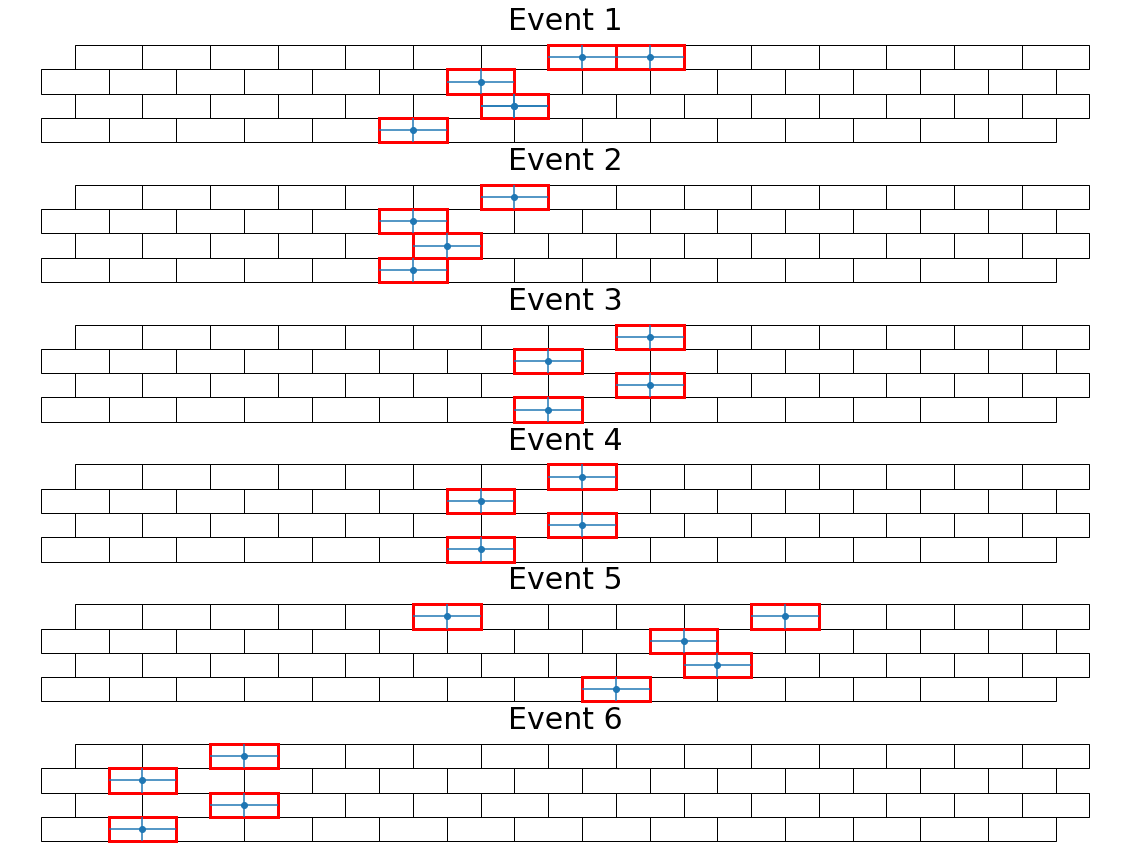

In [15]:
#draw new events
dx=1
dy=1/2

fig,(ax1,ax2,ax3,ax4,ax5,ax6)=plt.subplots(nrows=6,ncols=1,figsize=(20,15))

ax1.set_title("Event 1",fontsize=30)
draw_detector(ax1)
boxes(ax1,centres(event0)[0],centres(event0)[1])
ax1.errorbar(centres(event0)[0],centres(event0)[1],dy/2,dx/2,fmt='o')
#traj(ax1,centres(event0)[0],centres(event0)[1])

ax2.set_title("Event 2",fontsize=30)
draw_detector(ax2)
boxes(ax2,centres(event1)[0],centres(event1)[1])
ax2.errorbar(centres(event1)[0],centres(event1)[1],dy/2,dx/2,fmt='o')
#traj(ax2,centres(event1)[0],centres(event1)[1])

ax3.set_title("Event 3",fontsize=30)
draw_detector(ax3)
boxes(ax3,centres(event2)[0],centres(event2)[1])
ax3.errorbar(centres(event2)[0],centres(event2)[1],dy/2,dx/2,fmt='o')
#traj(ax3,centres(event2)[0],centres(event2)[1])

ax4.set_title("Event 4",fontsize=30)
draw_detector(ax4)
boxes(ax4,centres(event3)[0],centres(event3)[1])
ax4.errorbar(centres(event3)[0],centres(event3)[1],dy/2,dx/2,fmt='o')
#traj(ax4,centres(event3)[0],centres(event3)[1])


ax5.set_title("Event 5",fontsize=30)
draw_detector(ax5)
boxes(ax5,centres(event4)[0],centres(event4)[1])
ax5.errorbar(centres(event4)[0],centres(event4)[1],dy/2,dx/2,fmt='o')
#traj(ax5,centres(event4)[0],centres(event4)[1])

ax6.set_title("Event 6",fontsize=30)
draw_detector(ax6)
boxes(ax6,centres(event5)[0],centres(event5)[1])
ax6.errorbar(centres(event5)[0],centres(event5)[1],dy/2,dx/2,fmt='o')
#traj(ax6,centres(event5)[0],centres(event5)[1])

plt.show()



Come si può notare dalle immagini precedenti, a meno di mancata ricezione di segnali, gli eventi in questa forma non possono rappresentare delle traiettorie rettilinee di una particella. Abbiamo deciso pertanto di selezionare un'ultima volta gli eventi, conservando quelli che consentono alla particella di avere una traiettoria rettilinea e scartando gli altri.

In [32]:
#SIXTH CUT
#select only cells that are close in the detector

def close(group):
    
    group1=group.drop(group[group['DETECTOR']==0].index)\
    .sort_values('LAYER') #event without trigger and sorted by LAYER
    
    #distances between cells
    x=pd.Series(centres(group1)[0]).diff().abs()
    y=pd.Series(centres(group1)[1]).diff().abs()
    
    if ((x>1)|(y>1)).any()==True: return None
    else: return group
    
    
filtered6=filtered5.groupby(['ORBIT_CNT'],group_keys=False)\
                    .apply(close)\
                    .dropna()\
                    .reset_index()\
                    .drop(['index'],axis=1) #LONG RUNTIME!!!


orbits=filtered6['ORBIT_CNT'].nunique()

print("Number of unique orbits:",orbits)
print("Samples in reduced dataset:",filtered6.shape[0])
print("Percentage of the original dataset:",filtered6.shape[0]*100/samples,"%")


filtered6

Number of unique orbits: 26503
Samples in reduced dataset: 137298
Percentage of the original dataset: 10.625743928997636 %


,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
0,13.0,1.897417e+09,445.0,24.0,11145.000000,3.0,4.0
1,14.0,1.897417e+09,450.0,9.0,11257.500000,3.0,2.0
2,16.0,1.897417e+09,452.0,17.0,11314.166667,3.0,1.0
3,139.0,1.897417e+09,454.0,0.0,11350.000000,0.0,0.0
4,15.0,1.897417e+09,458.0,9.0,11457.500000,3.0,3.0
5,89.0,1.897417e+09,300.0,27.0,7522.500000,2.0,4.0
6,92.0,1.897417e+09,303.0,10.0,7583.333333,2.0,1.0
7,90.0,1.897417e+09,308.0,2.0,7701.666667,2.0,2.0
8,91.0,1.897417e+09,311.0,18.0,7790.000000,2.0,3.0
9,139.0,1.897417e+09,313.0,0.0,7825.000000,0.0,0.0


La versione finale del nostro dataset corrisponde al 10% della mole di dati iniziale. Questa forte riduzione è chiaramente motivata dalla lunga serie di condizioni che abbiamo imposto sui dati, al fine di poterli rendere trattabili con l'approccio richiesto dal nostro progetto.

In [20]:
def Time_Max_Filer(x):
        
        if (x.DETECTOR==0).sum() == 0:
            return None
            
            
        if (x.DETECTOR==0).sum() == 1:
        
            trigger_time = x[x.DETECTOR==0].TIME.values.min()
            x1 =  x[(x.TIME.values - trigger_time < 430)*(x.TIME.values - trigger_time > 0)]
            x1['DRIFT_TIME'] = x1.TIME.values - trigger_time
            
            return x1

In [22]:
filtered6 = filtered6.groupby('ORBIT_CNT', group_keys=False).apply(Time_Max_Filer)

In [31]:
filtered6

TDC_CHANNEL     ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
ORBIT_CNT                                                              
1.897417e+09 4              15.0  1.897417e+09       458.0       9.0   
1.897420e+09 54            103.0  1.897420e+09      2471.0      22.0   
1.897432e+09 126            66.0  1.897432e+09       652.0      26.0   
1.897438e+09 197            75.0  1.897438e+09      3475.0      28.0   
1.897445e+09 244             8.0  1.897445e+09      1526.0      19.0   
1.897448e+09 272            21.0  1.897448e+09      2588.0       5.0   
1.897463e+09 430            30.0  1.897463e+09       241.0      10.0   
1.897496e+09 732            53.0  1.897496e+09      1200.0      27.0   
             733            56.0  1.897496e+09      1201.0      21.0   
             737            44.0  1.897496e+09      1025.0       8.0   
             738            43.0  1.897496e+09      1028.0      24.0   
1.897502e+09 784            38.0  1.897502e+09      2773.0       4.0   
1.897509e+09 833            24.0  1.897509e+09       665.0      19.0   
             834            22.0  1.897509e+09       668.0      22.0   
             835            21.0  1.897509e+09       669.0      21.0   
1.897520e+09 916           118.0  1.897520e+09       479.0      19.0   
1.897521e+09 940            90.0  1.897521e+09      1984.0      18.0   
1.897528e+09 1018           46.0  1.897528e+09      2396.0      22.0   
1.897538e+09 1097            5.0  1.897538e+09      3067.0       8.0   
             1098            6.0  1.897538e+09      3067.0      28.0   
             1112          120.0  1.897538e+09       188.0      18.0   
             1113          118.0  1.897538e+09       191.0      29.0   
             1114          117.0  1.897538e+09       196.0       7.0   
1.897539e+09 1143           30.0  1.897539e+09       770.0      12.0   
             1144           29.0  1.897539e+09       771.0      10.0   
1.897540e+09 1153           90.0  1.897540e+09      3487.0      10.0   
             1154           89.0  1.897540e+09      3487.0      16.0   
1.897541e+09 1189            7.0  1.897541e+09      3262.0       3.0   
             1193           31.0  1.897541e+09      3527.0      29.0   
             1194           32.0  1.897541e+09      3529.0      29.0   
...                          ...           ...         ...       ...   
1.920940e+09 137189         84.0  1.920940e+09        41.0       7.0   
             137190         83.0  1.920940e+09        41.0      26.0   
             137194         23.0  1.920940e+09      3396.0      27.0   
             137195         24.0  1.920940e+09      3397.0       1.0   
             137199         18.0  1.920940e+09      2005.0      25.0   
             137200         17.0  1.920940e+09      2006.0       0.0   
             137204         23.0  1.920940e+09       220.0      24.0   
             137205         24.0  1.920940e+09       222.0      23.0   
             137210         26.0  1.920940e+09      2771.0       9.0   
             137221          3.0  1.920940e+09      2710.0      18.0   
             137222          1.0  1.920940e+09      2712.0      26.0   
             137226         21.0  1.920940e+09       298.0       8.0   
             137227         22.0  1.920940e+09       298.0      16.0   
             137231         33.0  1.920940e+09      2132.0      14.0   
             137232         34.0  1.920940e+09      2132.0      18.0   
             137237        113.0  1.920940e+09      1548.0      29.0   
             137241         29.0  1.920940e+09       616.0       4.0   
             137242         30.0  1.920940e+09       616.0       5.0   
             137247          9.0  1.920940e+09      3469.0       1.0   
             137256         22.0  1.920940e+09      2623.0      24.0   
             137257         21.0  1.920940e+09      2624.0      10.0   
             137266         14.0  1.920940e+09      3052.0      17.0   
             137267         13.0  1.920940e+09      3053.0   

In [30]:
filtered6[filtered6['ORBIT_CNT'] == 

SyntaxError: unexpected EOF while parsing (<ipython-input-30-8f4a8782c184>, line 1)

In [28]:
1.920940e+09

1920940000.0